# Alt JS, ST for full Boston Housing dataset

In [1]:
import shap
import sklearn
import numpy as np
import pandas as pd

from random import uniform
import time
from IPython.display import display, clear_output

from joint_shapley import * # Where most of the JS code is 

#### Import dataset

In [2]:
X,y = shap.datasets.boston()
X = X
y = y

In [3]:
np.random.seed(0)
test_train_split = np.random.uniform(0, 1, len(y)) <= .75
train_X = X[test_train_split]
train_y = y[test_train_split]
test_X = X[~test_train_split]
test_y = y[~test_train_split]

In [4]:
x_labels = X.columns
n = len(x_labels)
print(f"Dataset has {n} features and {len(y)} observations")

Dataset has 13 features and 506 observations


#### The empty set is included the coalition sets, so we need a proxy ML model for it

In [5]:
model = sklearn.ensemble.RandomForestRegressor(
    n_jobs=10, n_estimators=50,random_state=0
).fit(train_X, train_y)

In [6]:
%pdb

for k in range(1, 2):
    print(f"Starting calculation for k = {k}")
    n_cln = frozenset(x_labels)
    full_powerset = list(get_powerset(n_cln))
    powerset_to_k = list(get_powerset_to_k(n_cln, k))
    q_values = get_q_values(n, k)

    coalition_predictions = {}
    for cln in full_powerset:
        cln_X = test_X.copy()
        cln_X.loc[:, [col not in cln for col in X.columns]] = \
        test_X.mean(axis=0).loc[[col not in cln for col in X.columns]].values.T
        coalition_predictions[cln] = model.predict(cln_X)
        
    explainer = shap.Explainer(model)
    shap_values = explainer(train_X)
    baseline = shap_values.base_values
    # Sort for better output
    lst_coalitions_to_k = [", ".join(sorted(fs)) for fs in powerset_to_k if fs != EMPTY]
    sorted_coalitions_to_k = sorted(lst_coalitions_to_k, key = lambda x: (len(x), x))
    local_shapley_taylors = pd.DataFrame(columns = sorted_coalitions_to_k)
    local_joint_shapleys = pd.DataFrame(columns = sorted_coalitions_to_k)

    for num, (_, observation) in enumerate(test_X.iterrows()):
        clear_output(wait=True)
        display(f"Processing k = {k}, row {num} / {len(test_y)}")
        value_function = lambda cln: coalition_predictions[cln][num]# - baseline[num][0] # Set value function
        #local_st = get_shapley_taylors(value_function, n_cln, k) # Create row
        #local_st_parsed = {", ".join(sorted(fs)): val for fs, val in local_st.items()}
        #local_shapley_taylors = local_shapley_taylors.append(local_st_parsed, ignore_index=True) # Then add row to df
        local_js = get_k_extended_joint_shapleys(value_function, n_cln, q_values, k)
        local_js_parsed = {", ".join(sorted(fs)): val for fs, val in local_js.items()}
        local_joint_shapleys = local_joint_shapleys.append(local_js_parsed, ignore_index=True) # Then add row to df
    print(f"Exporting data for k = {k} to csv")
    #local_shapley_taylors.to_csv(f"./boston_csv_output/alt_rf_st_k_{k}.csv")
    #global_shapley_taylors = np.abs(local_shapley_taylors).mean(axis=0)
    #global_shapley_taylors.to_csv(f"./boston_csv_output/alt_rf_global_st_k_{k}.csv")
    local_joint_shapleys.to_csv(f"./results/alt_rf_js_k_{k}.csv")
    global_joint_shapleys = np.abs(local_joint_shapleys).mean(axis=0)
    global_joint_shapleys.to_csv(f"./results/alt_rf_global_js_k_{k}.csv")

'Processing k = 1, row 120 / 121'

Exporting data for k = 1 to csv


In [25]:
(shap_values.values + shap_values.base_values).mean(axis=0)

array([23.009312, 22.833064, 22.861143, 22.8349  , 22.822298, 22.277194,
       22.807036, 23.135534, 22.838183, 22.803847, 22.800274, 22.885129,
       21.884993])

In [22]:
shap_values.values.mean(axis=0)

array([ 0.170444, -0.005803,  0.022276, -0.003968, -0.01657 , -0.561674,
       -0.031832,  0.296666, -0.000685, -0.035021, -0.038593,  0.046262,
       -0.953875])

In [12]:
local_joint_shapleys.sum(axis=1).mean()

21.726495867768595

#### Global Shapleys from SHAP Package

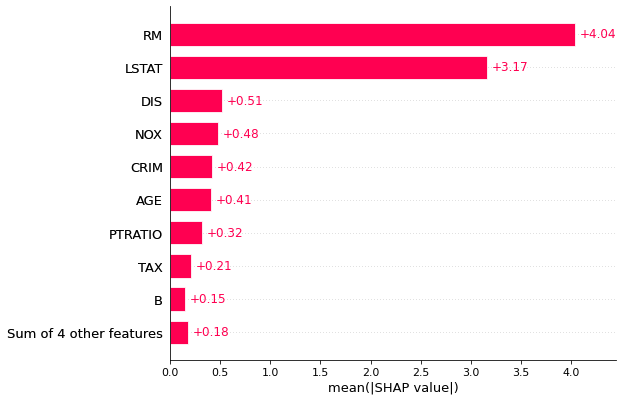

In [8]:
y_predicted = model.predict(test_X)
explainer = shap.Explainer(model)
shap_values = explainer(test_X)
shap.plots.bar(shap_values)

In [9]:
global_joint_shapleys

B          1.547380
RM         3.395768
ZN         1.684237
AGE        1.374207
DIS        1.938991
NOX        1.479788
RAD        1.641434
TAX        1.819698
CHAS       1.689696
CRIM       1.358832
INDUS      1.636113
LSTAT      2.742904
PTRATIO    1.656256
           0.000000
dtype: float64